
# K-Prototypes en datos mixtos — v3 (simple y didáctica)

**Objetivo**: Segmentar clientes con **K-Prototypes** usando el dataset de Kaggle *Customer Personality Analysis*.

1. **Método del codo** para elegir `k` (3→8) usando el `cost_` del modelo.  
2. **Silhouette (aproximado)** solo para `k = 3, 4, 5` calculado sobre datos **codificados y escalados** (One‑Hot + z‑score).  
   > ⚠️ *Nota*: Este **Silhouette es un proxy**. No usa la métrica mixta interna de K‑Prototypes; sirve para comparar grosso modo 3/4/5.
3. **Modelo final** (elige `FINAL_K`) y visualización con **PCA 2D** y **PCA 3D (Plotly)**.
4. **Violin plots** para interpretar variables por cluster, con un **split binario** de `Marital_Status` → `Has_Partner` (0/1).

**Dataset**: `marketing_campaign.csv` (separador `\t`), descargar desde Kaggle y colocar junto a este notebook.



In [1]:

# Dependencias (descomentar si hace falta instalarlas)
# !pip install pandas numpy scikit-learn kmodes matplotlib seaborn plotly


In [2]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from kmodes.kprototypes import KPrototypes

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.decomposition import PCA
import plotly.express as px

pd.set_option('display.max_columns', 120)



## 1) Carga y preparación de datos


In [ ]:

csv_path = "marketing_campaign_2.csv"
df_raw = pd.read_csv(csv_path, sep='\t')

df = df_raw.dropna(subset=['Income']).copy()

CURRENT_YEAR = 2025
df['Age'] = CURRENT_YEAR - df['Year_Birth']

cat_cols = ['Education', 'Marital_Status']
num_cols = [
    'Age','Income','Kidhome','Teenhome','Recency',
    'MntWines','MntFruits','MntMeatProducts',
    'MntFishProducts','MntSweetProducts','MntGoldProds'
]

df = df[num_cols + cat_cols].copy()

for c in cat_cols:
    df[c] = df[c].astype('category')

cat_idx = [df.columns.get_loc(c) for c in cat_cols]

df.head()


,Age,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,Education,Marital_Status
0,68,58138.0,0,0,58,635,88,546,172,88,88,Graduation,Single
1,71,46344.0,1,1,38,11,1,6,2,1,6,Graduation,Single
2,60,71613.0,0,0,26,426,49,127,111,21,42,Graduation,Together
3,41,26646.0,1,0,26,11,4,20,10,3,5,Graduation,Together
4,44,58293.0,1,0,94,173,43,118,46,27,15,PhD,Married



## 2) Método del codo (k = 3 → 8) con `kproto.cost_`


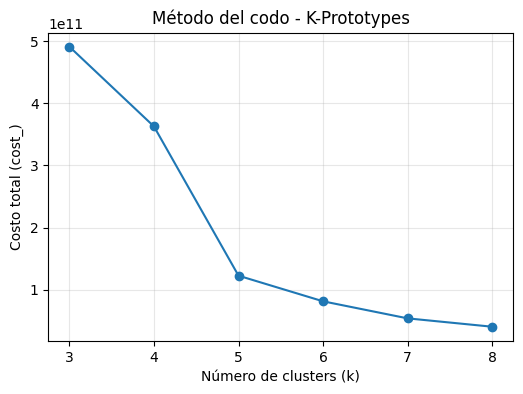

In [5]:

costs = []
K = list(range(3, 8+1))

for k in K:
    model = KPrototypes(n_clusters=k, init='Cao', random_state=42)
    _ = model.fit_predict(df, categorical=cat_idx)
    costs.append(model.cost_)

plt.figure(figsize=(6,4))
plt.plot(K, costs, marker='o')
plt.title('Método del codo - K-Prototypes')
plt.xlabel('Número de clusters (k)')
plt.ylabel('Costo total (cost_)')
plt.grid(True, alpha=0.3)
plt.show()



## 3) Silhouette **aproximado** para k = 3, 4 y 5


In [6]:

ct = ColumnTransformer([
    ('num', StandardScaler(), num_cols),
    ('cat', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), cat_cols)
])
X_proxy = ct.fit_transform(df)

sil_results = {}

for k in [3,4,5]:
    model = KPrototypes(n_clusters=k, init='Cao', random_state=42)
    labels = model.fit_predict(df, categorical=cat_idx)
    sil = silhouette_score(X_proxy, labels)
    sil_results[k] = {'sil': sil, 'labels': labels}
    print(f"k={k} | Silhouette (aprox): {sil:.3f}")


k=3 | Silhouette (aprox): 0.193
k=4 | Silhouette (aprox): 0.085
k=5 | Silhouette (aprox): 0.021



### Gráficos de Silhouette (aprox) por cluster para k = 3, 4 y 5


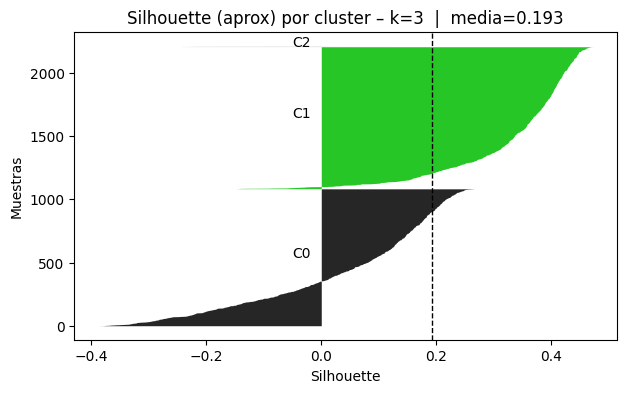

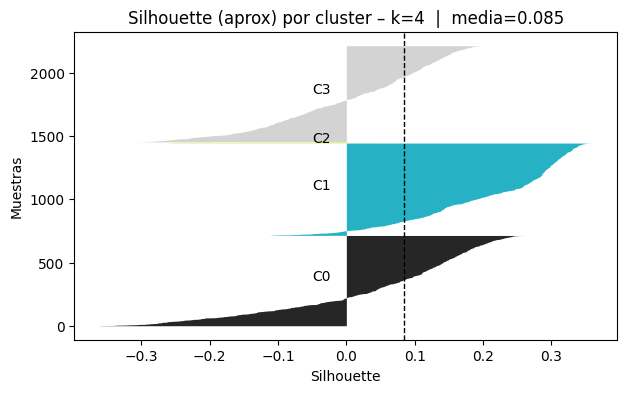

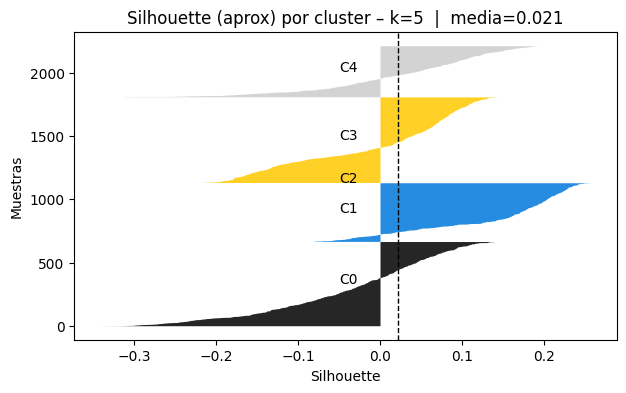

In [7]:

from matplotlib import cm

for k in [3,4,5]:
    labels = sil_results[k]['labels']
    svals = silhouette_samples(X_proxy, labels)

    n_clusters = len(np.unique(labels))
    colors = cm.nipy_spectral(np.linspace(0, 1, n_clusters))

    y_lower = 0
    plt.figure(figsize=(7,4))
    for i, c in enumerate(sorted(np.unique(labels))):
        sv = np.sort(svals[labels == c])
        y_upper = y_lower + len(sv)
        plt.fill_betweenx(np.arange(y_lower, y_upper), 0, sv, color=colors[i], alpha=0.85, linewidth=0)
        plt.text(-0.05, y_lower + 0.5*len(sv), f"C{c}")
        y_lower = y_upper

    plt.axvline(np.mean(svals), color='black', linestyle='--', linewidth=1)
    plt.title(f"Silhouette (aprox) por cluster – k={k}  |  media={np.mean(svals):.3f}")
    plt.xlabel("Silhouette"); plt.ylabel("Muestras")
    plt.show()



## 4) Modelo final (elige `FINAL_K` según codo + silhouette aprox)


In [8]:

FINAL_K = 4  # <-- ajusta si lo deseas
kproto_final = KPrototypes(n_clusters=FINAL_K, init='Cao', random_state=42)
labels_final = kproto_final.fit_predict(df, categorical=cat_idx)

df_final = df.copy()
df_final['cluster'] = labels_final

print("Costo final:", kproto_final.cost_)
print("Tamaños por cluster:\n", df_final['cluster'].value_counts().sort_index())


Costo final: 362867213175.0669
Tamaños por cluster:
 cluster
0    715
1    731
2      8
3    762
Name: count, dtype: int64



## 5) PCA 2D y 3D (Plotly) para visualizar los clusters del modelo final
> Para PCA convertimos categóricas a **códigos** solo para graficar (no afecta el modelo).


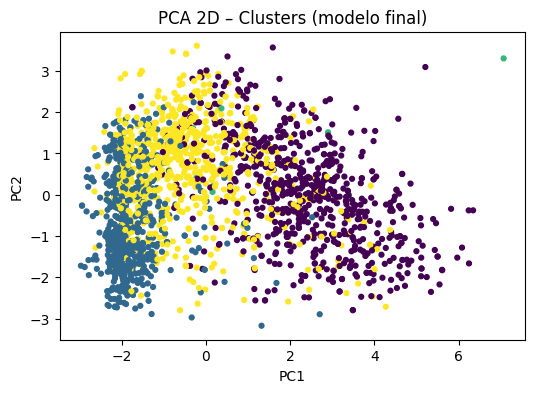

Varianza explicada (PC1, PC2): [0.32703708 0.1282471 ]


Varianza explicada (PC1..PC3): [0.32703708 0.1282471  0.08104261]


In [9]:

# Codificar categóricas a códigos (solo PCA)
df_pca = df_final.copy()
for c in cat_cols:
    df_pca[c] = df_pca[c].cat.codes if hasattr(df_pca[c], 'cat') else df_pca[c]

scaler_pca = StandardScaler()
X_pca = scaler_pca.fit_transform(df_pca[num_cols + cat_cols])

# PCA 2D
pca2 = PCA(n_components=2)
p2 = pca2.fit_transform(X_pca)

plt.figure(figsize=(6,4))
plt.scatter(p2[:,0], p2[:,1], c=df_final['cluster'], s=12)
plt.title('PCA 2D – Clusters (modelo final)')
plt.xlabel('PC1'); plt.ylabel('PC2')
plt.show()
print("Varianza explicada (PC1, PC2):", pca2.explained_variance_ratio_)

# PCA 3D (Plotly)
pca3 = PCA(n_components=3)
p3 = pca3.fit_transform(X_pca)

import plotly.express as px
df_plotly = pd.DataFrame({'PC1': p3[:,0], 'PC2': p3[:,1], 'PC3': p3[:,2], 'Cluster': df_final['cluster'].astype(str)})
fig = px.scatter_3d(df_plotly, x='PC1', y='PC2', z='PC3', color='Cluster', opacity=0.75,
                    title='PCA 3D interactivo – Clusters (modelo final)')
fig.update_traces(marker=dict(size=4))
fig.show()
print("Varianza explicada (PC1..PC3):", pca3.explained_variance_ratio_)



## 6) Violin plots + split binario por pareja
Creamos `Has_Partner` desde `Marital_Status` (1: con pareja → Married/Together; 0: sin pareja → Single/Divorced/Widow).


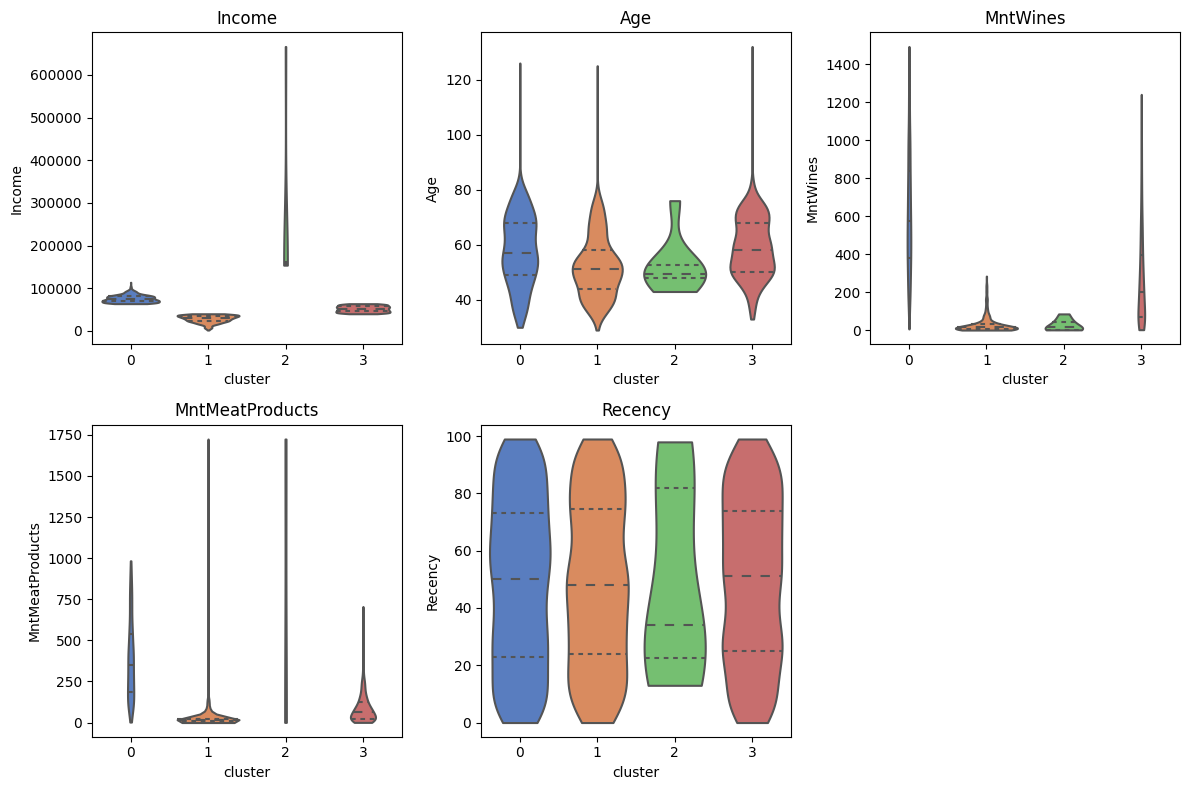

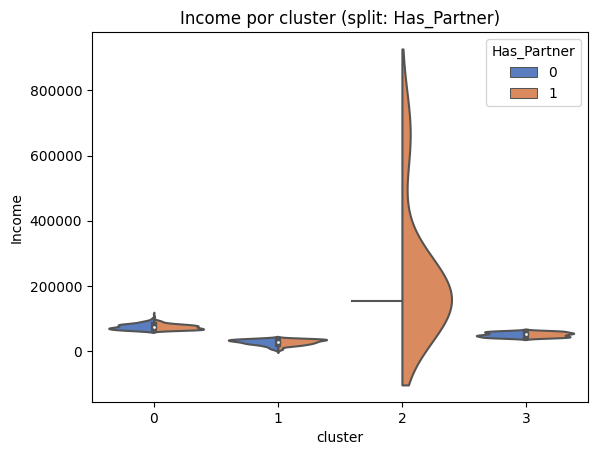

In [21]:
sns.set_palette("muted")

# 1 si tiene pareja (Married/Together), 0 en cualquier otro caso
df_final['Has_Partner'] = df_final['Marital_Status'].isin(['Married', 'Together']).astype(int).astype('object')
vars_violin = ['Income','Age','MntWines','MntMeatProducts','Recency']

# Violines por cluster (sin hue)
plt.figure(figsize=(12,8))
for i, col in enumerate(vars_violin, 1):
    plt.subplot(2, 3, i)
    sns.violinplot(data=df_final, x='cluster', y=col, inner='quartile', cut=0)
    plt.title(col)
plt.tight_layout(); plt.show()

# Violín con split binario (Has_Partner)
sns.violinplot(data=df_final, x='cluster', y='Income', hue='Has_Partner', split=True)
plt.title('Income por cluster (split: Has_Partner)')
plt.show()


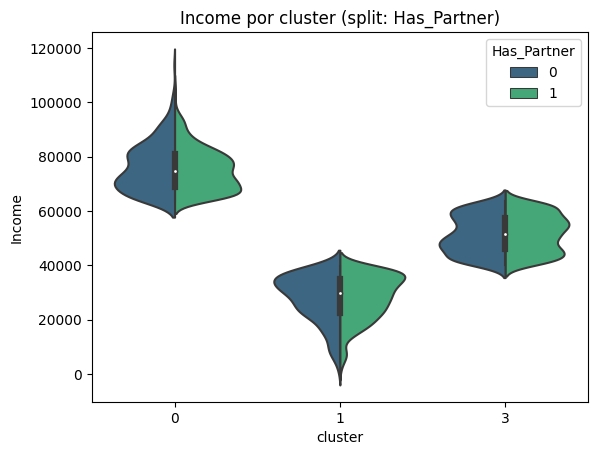

In [24]:
# Violín sin cluster 2
sns.violinplot(data=df_final[df_final['cluster'] != 2], x='cluster', y='Income', hue='Has_Partner', split=True, palette = 'viridis')
plt.title('Income por cluster (split: Has_Partner)')
plt.show()



---
### Notas finales
- En `KPrototypes(...).fit_predict(df, categorical=cat_idx)` pasamos **todas** las columnas mixtas; `cat_idx` marca cuáles son categóricas.
- El **Silhouette aproximado** usa One‑Hot + z‑score y métrica euclidiana; es útil para comparar 3/4/5 pero **no** es la métrica mixta real del modelo.
- Si aparece un cluster muy pequeño, probablemente sean **outliers** o un grupo residual; analízalo aparte.
